# <center>Вариация модели Басса для распространения инноваций по регионам

### Постановака задачи

#### Одномерный случай:


$ A(t) - adopters \\ 
plA(t) - potential \quad adopters \\
p - total \quad population \\
adv - advertising \quad effect \\
c - contact \quad rate \\
af - adoption \quad fraction $

#### Модель: 

$$ \begin{cases} 
A(t) = A(t - 1) + pA(t - 1)(adv + \frac{A(t-1)}{p} *c * af) \\
pA(t) = pA(t -1) * (1 - adv - \frac{A(t-1)}{p} *c * af) \\
A(0) = 0 \\ 
pA(0) = p \\
\end{cases}
$$

Расширим эту модель следующим образом:

Добавим возможность отрицательного влияния.
<li> Пусть теперь с некоторой вероятностью потенциальные покупатели не станут покупателями </li>
<li> То есть уже не все потенциальные покупатели станут покупателями </li>

Пусть теперь есть несколько регионов.
<li> Добавим влияние соседних регионов друг на друга. </li>
<li> Оно может быть как положительным, так и отрицательным </li>

#### Многомерный случай:


$ A_i(t) - adopters \quad in \quad i \quad region\\ 
plA_i(t) - potential \quad adopters \quad in \quad i \quad region\\
p_i - total \quad population \quad in \quad i \quad region\\
adv_i - advertising \quad effect \quad in \quad i \quad region\\
c_i - contact \quad rate \quad in \quad i \quad region\\
af_i - adoption \quad fraction \quad in \quad i \quad region\\
prob_i - probability \quad in \quad i \quad region \\
X_{ij} - connection \quad between \quad i \quad and \quad j
$

#### Модель: 

$$ \begin{cases} 
A_i(t) = A_i(t - 1) + pA_i(t - 1)(adv_i + res(prob_{it}) * \frac{A_i(t-1)}{p_i} *c_i * af_i + \sum_{j}^{neigbours} res(prob_{jt}) * \frac{A_j(t-1)}{p_j} *c_j * af_i * X_{ij}) \\
pA_i(t) = pA_i(t -1) * (1 - adv_i - \frac{A_i(t-1)}{p_i} *c_i * af_i - \sum_{j}^{neigbours}  \frac{A_j(t-1)}{p_j} *c_j * af_i * X_{ij}) \\
A_i(0) = 0 \\ 
pA_i(0) = p_i \\
\end{cases}
$$

#### Можно упростить как: 

$$ \begin{cases} 
A_i(t) = A_i(t - 1) + pA_i(t - 1)(adv_i + \sum_{ij}^{neigbours} res(prob_{jt}) * \frac{A_j(t-1)}{p_j} *c_j * af_i * X_{ij}) \\
pA_i(t) = pA_i(t -1) * (1 - adv_i  - \sum_{ij}^{neigbours}  \frac{A_j(t-1)}{p_j} *c_j * af_i * X_{ij}) \\
A_i(0) = 0 \\ 
pA_i(0) = p_i \\ 
X_{ii} = 1 \quad \forall i
\end{cases}
$$

## Начальные данные

Рассмотрим федеральные округа

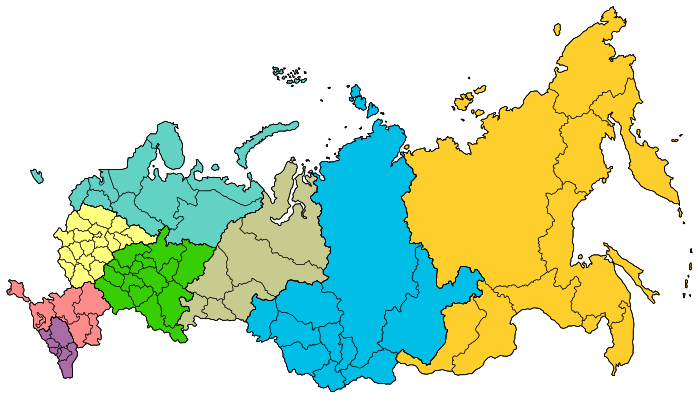

<p> 1 - центральный федеральный округ</p>
<p> 2 - северо-западный федеральный округ</p>
<p> 3 - уральский федеральный округ</p>
<p> 4 - южный федеральный округ</p>
<p> 5 - приволжский федеральный округ</p>

In [1]:
p1 = 39311413; #численность населения
p2 = 13952003;
p3 = 12356229;
p4 = 16441852;
p5 = 29542696;

adv1 = 0.05; # эффективность рекламы
adv2 = 0.04;
adv3 = 0;
adv4 = 0;
adv5 = 0;

c1 = 2; # сарафанное радио
c2 = 4;
c3 = 6;
c4 = 12;
c5 = 8;

af1 = 0.02;
af2 = 0.02;
af3 = 0.02;
af4 = 0.02;
af5 = 0.02;

prob1 = 0.8; # вероятность положительного влияния
prob2 = 0.6;
prob3 = 0.85;
prob4 = 0.9;
prob5 = 0.75;

### Импорты

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Матрица связи
Матрица Х может быть как симметричной, так и нет. 


Если матрица симметрична - округа влияют друг на друга в одинаковой степени. 

In [3]:
X = np.eye(5) 
X[0,1] = 0.05 
X[1,0] = 0.05
X[1,2] = 0.05
X[2,1] = 0.02
X[0,4] = 0.04
X[4,0] = 0.02
X[1,4] = 0.03
X[4,1] = 0.03
X[2,4] = 0.04
X[4,2] = 0.05
X[0,3] = 0.04
X[3,0] = 0.02
X[2,3] = 0.04
X[3,2] = 0.03

In [4]:
X

array([[1.  , 0.05, 0.  , 0.04, 0.04],
       [0.05, 1.  , 0.05, 0.  , 0.03],
       [0.  , 0.02, 1.  , 0.04, 0.04],
       [0.02, 0.  , 0.03, 1.  , 0.  ],
       [0.02, 0.03, 0.05, 0.  , 1.  ]])

## Вспомогательные функции

Случайный эксперимент, симулирующий поведение каждого из a покупателей.

In [72]:
def res_prob(prob, a): 
    if a == 0:
        return prob
    else:
        return len(list(filter(lambda x: x < prob, [np.random.rand(1)[0] for i in range(int(a))]))) / a

In [73]:
def get_connections(X, A, prob, c, af, t, i, check):
    if check == 1:
        #print(prob[1],A[1][t-1], res_prob(prob[1], A[1][t-1]))
        #l = [res_prob(prob[j], A[j][t-1])*(A[j][t - 1] / p[j]) * c[j] * af[j] * X[j,i] for j in range(5)]
        #l1= [(A[j][t - 1] / p[j]) * c[j] * af[j] * X[j,i] for j in range(5)]
        #l2 = [(A[j][t - 1]) for j in range(5)]
        #print(l, l1, l2)
        return sum([res_prob(prob[j], A[j][t-1])*(A[j][t - 1] / p[j]) * c[j] * af[j] * X[j,i] for j in range(5)])
    else:
        return sum([(A[j][t - 1] / p[j]) * c[j] * af[j] * X[j,i] for j in range(5)])

## Реализация

In [74]:
A = [[0] for i in range(5)];
pA = [[p1], [p2], [p3], [p4], [p5]];
p = [p1, p2, p3, p4, p5];
c = [c1, c2, c3, c4, c5];
adv = [adv1, adv2, adv3, adv4, adv5];
af = [af1, af2, af3, af4, af5];
prob = [prob1, prob2, prob3, prob4, prob5];

In [75]:
def imitation(time_limit, A, pA, p, c, adv, af, prob):
    for t in range(1, time_limit):
        print(t)
        A1 = A
        pA1 = pA
        print(A1)
        print(pA1)
        for i in range(5):
            A1[i].append(A1[i][t-1] + pA1[i][t-1] * (adv[i] + get_connections(X, A1, prob, c, af, t, i, 1)))
            pA1[i].append(pA1[i][t-1] * (1 - adv[i] - get_connections(X, A1, prob, c, af, t, i, 0)))
            print()
            print(A1)
            print(pA1)
    return [A1, pA1]

In [76]:
imitation(10, A, pA, p, c, adv, af, prob)

1
[[0], [0], [0], [0], [0]]
[[39311413], [13952003], [12356229], [16441852], [29542696]]

[[0, 1965570.6500000001], [0], [0], [0], [0]]
[[39311413, 37345842.35], [13952003], [12356229], [16441852], [29542696]]

[[0, 1965570.6500000001], [0, 558080.12], [0], [0], [0]]
[[39311413, 37345842.35], [13952003, 13393922.879999999], [12356229], [16441852], [29542696]]

[[0, 1965570.6500000001], [0, 558080.12], [0, 0.0], [0], [0]]
[[39311413, 37345842.35], [13952003, 13393922.879999999], [12356229, 12356229.0], [16441852], [29542696]]

[[0, 1965570.6500000001], [0, 558080.12], [0, 0.0], [0, 0.0], [0]]
[[39311413, 37345842.35], [13952003, 13393922.879999999], [12356229, 12356229.0], [16441852, 16441852.0], [29542696]]

[[0, 1965570.6500000001], [0, 558080.12], [0, 0.0], [0, 0.0], [0, 0.0]]
[[39311413, 37345842.35], [13952003, 13393922.879999999], [12356229, 12356229.0], [16441852, 16441852.0], [29542696, 29542696.0]]
2
[[0, 1965570.6500000001], [0, 558080.12], [0, 0.0], [0, 0.0], [0, 0.0]]
[[3931

KeyboardInterrupt: 

In [77]:
A

[[0, 1965570.6500000001, 3896197.6341626896],
 [0, 558080.12, 1120638.8402091628],
 [0, 0.0, 1185.411294809498],
 [0, 0.0, 1051.260335887494],
 [0, 0.0, 3591.3205839620864]]